# Classifying Skin Lesions
The ISIC Archive contains over 23k images of skin lesions, labeled as 'benign' or 'malignant'. The archive can be found here: https://www.isic-archive.com/#!/onlyHeaderTop/gallery

You can learn more about the project and data here: https://www.isic-archive.com/#!/topWithHeader/tightContentTop/about/isicArchive




In [0]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# The first time that you run this cell, you will need to authorize access in your drive. 
# Go to the link and copy the authorization code

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib
import matplotlib.pyplot as plt
import os

# Import the TF V2 through this magic command
%tensorflow_version 2.x

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

# Check the Version of the Tensor Flow. It should be the version 2
print(tf.__version__)

2.2.0-rc2


In [0]:
import keras
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from IPython.display import Image
from tensorflow.keras.optimizers import Adam

Using TensorFlow backend.


### Access the data
First, add the [Data folder](https://drive.google.com/open?id=1a85IldM96jUcKyPnu22_ZbOmwc2aoFre) to your Google Drive. Data for in-class examples and Problem Set 2 are in this folder.
Then change the path below and run the code to read in the data and look at one of the images. You can also download the images to your machine if you would like to run the code below in a Jupyter notebook.

In [0]:
base_dir = 'drive/My Drive/Teaching/BST 261/2020/Colab Notebooks/In-class examples/Data/skin_lesions/'
# Path for students 
# base_dir = 'drive/My Drive/Data/skin_lesions/'

In [0]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_benign_dir = os.path.join(base_dir, 'train/benign')
train_malignant_dir = os.path.join(base_dir, 'train/malignant')
validation_benign_dir = os.path.join(base_dir, 'validation/benign')
validation_malignant_dir = os.path.join(base_dir, 'validation/malignant')
test_benign_dir = os.path.join(base_dir, 'test/benign')
test_malignant_dir = os.path.join(base_dir, 'test/malignant')

In [0]:
# Let's check the number of images in each set
print('Total training benign images:', len(os.listdir(train_benign_dir)))
print('Total training malignant images:', len(os.listdir(train_malignant_dir)))
print('Total validation benign images:', len(os.listdir(validation_benign_dir)))
print('Total validation malignant images:', len(os.listdir(validation_malignant_dir)))
print('Total test benign images:', len(os.listdir(test_benign_dir)))
print('Total test malignant images:', len(os.listdir(test_malignant_dir)))

Total training benign images: 810
Total training malignant images: 799
Total validation benign images: 226
Total validation malignant images: 200
Total test benign images: 191
Total test malignant images: 201


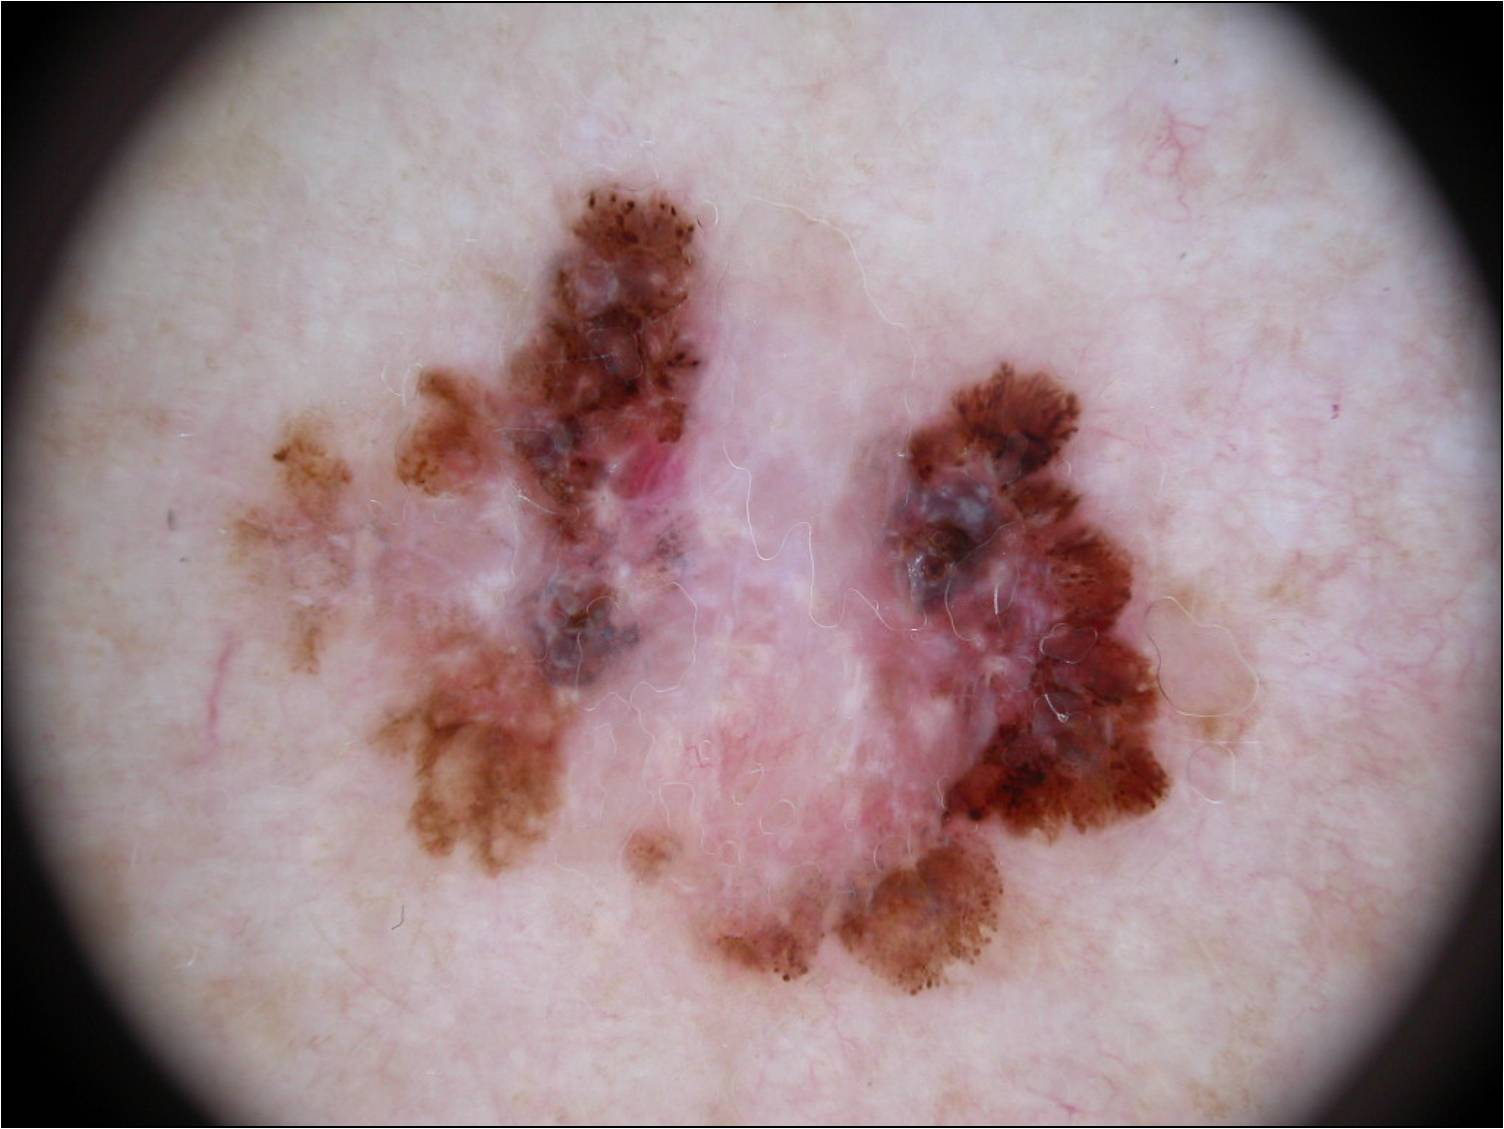

In [0]:
Image(filename= base_dir + 'train/malignant/malignant.2.jpg')

## Creating a CNN from scratch
We've already built a small CNN using the MNIST dataset. We will reuse the same general structure: our CNN will be a stack of alternated Conv2D (with relu activation) and MaxPooling2D layers.

However, since we are dealing with bigger images and a more complex problem, we will make our network accordingly larger: it will have one more `Conv2D` + `MaxPooling2D` stage. This serves both to augment the capacity of the network, and to further reduce the size of the feature maps, so that they aren't overly large when we reach the `Flatten` layer. Here, since we start from inputs of size 150x150 (a somewhat arbitrary choice), we end up with feature maps of size 7x7 right before the `Flatten` layer.

Note that the depth of the feature maps is progressively increasing in the network (from 32 to 128), while the size of the feature maps is decreasing (from 148x148 to 7x7). This is a pattern that you will see in almost all CNNs.

Since we are attacking a binary classification problem, we are ending the network with a single unit (a Dense layer of size 1) and a sigmoid activation. This unit will encode the probability that the network is looking at one class or the other.

In [0]:
# Define model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
  tf.keras.layers.MaxPooling2D((2, 2)),

  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),

  tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),

  tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),

  tf.keras.layers.Flatten(),

  tf.keras.layers.Dense(512, activation='relu'),

  tf.keras.layers.Dense(1, activation='sigmoid')
])

Print the summary of the model to inspect the architecture and the number of parameters that will be trained.

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

Define how to execute training

In [0]:
model.compile(loss = 'binary_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(lr=1e-4),
              metrics = ['accuracy'])

## Data preprocessing
As you already know by now, data should be formatted into appropriately pre-processed floating point tensors before being fed into our network. Currently, our data sits on a drive as JPEG files, so the steps for getting it into our network are roughly:

1. Read the picture files.
2. Decode the JPEG content to RBG grids of pixels.
3. Convert these into floating point tensors.
4. Rescale the pixel values (between 0 and 255) to the [0, 1] interval (as you know, neural networks prefer to deal with small input values).

It may seem a bit daunting, but thankfully Keras has utilities to take care of these steps automatically. Keras has a module with image processing helper tools, located at keras.preprocessing.image. In particular, it contains the class ImageDataGenerator which allows you to quickly set up Python generators that can automatically turn image files on disk into batches of pre-processed tensors. This is what we will use here.

In [0]:
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size = (150, 150),
        batch_size = 20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode = 'binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size = (150, 150),
        batch_size = 20,
        class_mode = 'binary')

Found 1609 images belonging to 2 classes.
Found 426 images belonging to 2 classes.


Let's take a look at the output of one of these generators: it yields batches of 150x150 RGB images (shape (20, 150, 150, 3)) and binary labels (shape (20,)). 20 is the number of samples in each batch (the batch size). Note that the generator yields these batches indefinitely: it just loops endlessly over the images present in the target folder. For this reason, we need to break the iteration loop at some point. We'll see this below.

In [0]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


Let's fit our model to the data using the generator. We do it using the `fit_generator` method, the equivalent of fit for data generators like ours. It expects as first argument a Python generator that will yield batches of inputs and targets indefinitely, like ours does. Because the data is being generated endlessly, the generator needs to know how many samples to draw from the generator before declaring an epoch over. This is the role of the `steps_per_epoch` argument: after having drawn `steps_per_epoch` batches from the generator, i.e. after having run for `steps_per_epoch` gradient descent steps, the fitting process will go to the next epoch. In our case, batches are 20-samples large, so it will take 81 batches until we see our target of 1609 training samples. Note: we use the **ceiling function** to calculate this number to ensure every example is used in training.

When using `fit_generator`, one may pass a `validation_data` argument, much like with the fit method. Importantly, this argument is allowed to be a data generator itself, but it could be a tuple of numpy arrays as well. If you pass a generator as `validation_data`, then this generator is expected to yield batches of validation data endlessly, and thus you should also specify the `validation_steps` argument, which tells the process how many batches to draw from the validation generator for evaluation. We use the ceiling function for this as well.

In [0]:
history = model.fit(
      train_generator,
      steps_per_epoch = 81, # ceil(1609/20)
      epochs = 30,
      validation_data = validation_generator,
      validation_steps = 22) # ceil(426/20)

Epoch 1/30
81/81 [==============================] - 1104s 14s/step - loss: 0.6777 - accuracy: 0.5693 - val_loss: 0.7193 - val_accuracy: 0.5399
Epoch 2/30
81/81 [==============================] - 395s 5s/step - loss: 0.5744 - accuracy: 0.6948 - val_loss: 0.8221 - val_accuracy: 0.5634
Epoch 3/30
81/81 [==============================] - 386s 5s/step - loss: 0.4947 - accuracy: 0.7383 - val_loss: 0.6373 - val_accuracy: 0.5376
Epoch 4/30
81/81 [==============================] - 392s 5s/step - loss: 0.4627 - accuracy: 0.7725 - val_loss: 0.6480 - val_accuracy: 0.5493
Epoch 5/30
81/81 [==============================] - 385s 5s/step - loss: 0.4290 - accuracy: 0.8036 - val_loss: 0.6824 - val_accuracy: 0.6338
Epoch 6/30
81/81 [==============================] - 389s 5s/step - loss: 0.3994 - accuracy: 0.8185 - val_loss: 0.5516 - val_accuracy: 0.6901
Epoch 7/30
81/81 [==============================] - 390s 5s/step - loss: 0.3807 - accuracy: 0.8160 - val_loss: 0.8970 - val_accuracy: 0.5657
Epoch 8/30



It is good practice to always save your models after training:

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
model.save('lesions_1.h5')
model_file = drive.CreateFile({'lesions_1' : 'lesions_1.h5'})
model_file.SetContentFile('lesions_1.h5')
model_file.Upload()
drive.CreateFile({'id': model_file.get('id')})

GoogleDriveFile({'id': '1DfDjIMzqgSNAnZayRGHiRsMSsjrEpE2c'})

Let's plot the loss and accuracy of the model over the training and validation data during training:

In [0]:
import seaborn as sns
sns.set()

train_acc  = history.history['accuracy']
train_loss = history.history['loss']
val_acc  = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

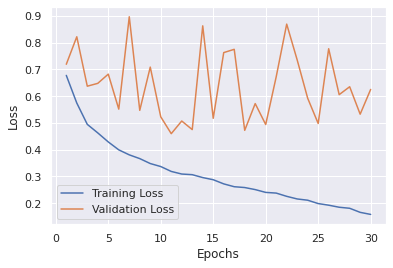

In [0]:
plt.plot(epochs, train_loss, label = 'Training Loss')
plt.plot(epochs, val_loss, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

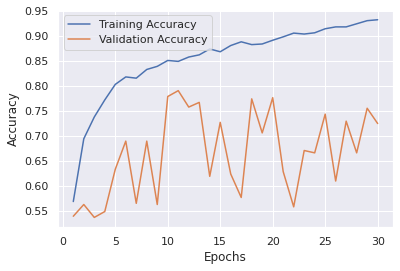

In [0]:
plt.plot(epochs, train_acc, label = 'Training Accuracy')
plt.plot(epochs, val_acc, label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

These plots are characteristic of overfitting. Our training accuracy increases linearly over time, until it reaches nearly 95%, while our validation accuracy stalls at 65-75% and oscillates a lot. Our validation loss starts to become unstable after only five epochs, while the training loss keeps decreasing linearly until it reaches nearly 0.

Because we only have relatively few training samples (1,609), overfitting is going to be our number one concern. You already know about a number of techniques that can help mitigate overfitting, such as dropout and weight decay (L2 regularization). We are now going to introduce a new one, specific to computer vision, and used almost universally when processing images with deep learning models: data augmentation.

## Data Augmentation
Overfitting is caused by having too few samples to learn from, rendering us unable to train a model able to generalize to new data. Given infinite data, our model would be exposed to every possible aspect of the data distribution at hand: we would never overfit. Data augmentation takes the approach of generating more training data from existing training samples, by "augmenting" the samples via a number of random transformations that yield believable-looking images. The goal is that at training time, our model would never see the exact same picture twice. This helps the model get exposed to more aspects of the data and generalize better.

In Keras, this can be done by configuring a number of random transformations to be performed on the images read by our `ImageDataGenerator` instance. Let's get started with an example:

In [0]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
      rotation_range = 40,
      width_shift_range = 0.2,
      height_shift_range = 0.2,
      shear_range = 0.2,
      zoom_range = 0.2,
      horizontal_flip = True,
      fill_mode = 'nearest')

These are just a few of the options available (for more, see the Keras documentation). Let's quickly go over what we just wrote:

* `rotation_range` is a value in degrees (0-180), a range within which to randomly rotate pictures.

* `width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.

* `shear_range` is for randomly applying shearing transformations.

* `zoom_range` is for randomly zooming inside pictures.

* `horizontal_flip` is for randomly flipping half of the images horizontally -- relevant when there are no assumptions of horizontal asymmetry (e.g. real-world pictures).

* `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

Let's take a look at our augmented images:

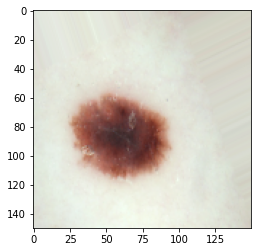

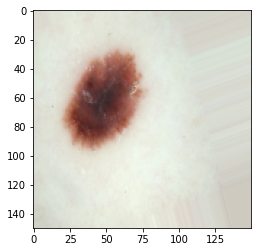

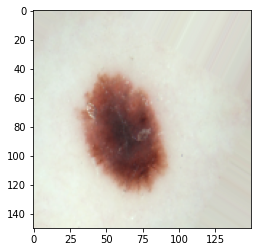

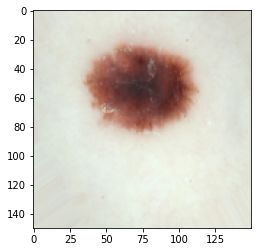

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
# This is module with image preprocessing utilities
from keras.preprocessing import image

fnames = [os.path.join(train_malignant_dir, fname) for fname in os.listdir(train_malignant_dir)]

# We pick one image to "augment"
img_path = fnames[3]

# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

If we train a new network using this data augmentation configuration, our network will never see twice the same input. However, the inputs that it sees are still heavily intercorrelated, since they come from a small number of original images -- we cannot produce new information, we can only remix existing information. As such, this might not be quite enough to completely get rid of overfitting. To further fight overfitting, we will also add a `Dropout` layer to our model, right before the densely-connected classifier:

In [0]:
# Define model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
  tf.keras.layers.MaxPooling2D((2, 2)),

  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),

  tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),

  tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),

  tf.keras.layers.Flatten(),

  tf.keras.layers.Dropout(0.5),

  tf.keras.layers.Dense(512, activation='relu'),

  tf.keras.layers.Dense(1, activation='sigmoid')
])


model.compile(loss = 'binary_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(lr=1e-4),
              metrics = ['accuracy'])


In [0]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')


history = model.fit(
      train_generator,
      steps_per_epoch=81,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=22)

Found 1609 images belonging to 2 classes.
Found 426 images belonging to 2 classes.
Epoch 1/30
81/81 [==============================] - 1240s 15s/step - loss: 0.6761 - accuracy: 0.5625 - val_loss: 0.6882 - val_accuracy: 0.3402
Epoch 2/30
81/81 [==============================] - 617s 8s/step - loss: 0.5984 - accuracy: 0.6767 - val_loss: 0.6913 - val_accuracy: 0.5652
Epoch 3/30
81/81 [==============================] - 636s 8s/step - loss: 0.5381 - accuracy: 0.7178 - val_loss: 0.7302 - val_accuracy: 0.5601
Epoch 4/30
81/81 [==============================] - 620s 8s/step - loss: 0.4936 - accuracy: 0.7490 - val_loss: 0.6267 - val_accuracy: 0.5970
Epoch 5/30
81/81 [==============================] - 624s 8s/step - loss: 0.4686 - accuracy: 0.7641 - val_loss: 0.5709 - val_accuracy: 0.7030
Epoch 6/30
81/81 [==============================] - 602s 7s/step - loss: 0.4531 - accuracy: 0.7781 - val_loss: 0.6348 - val_accuracy: 0.5836
Epoch 7/30
81/81 [==============================] - 622s 8s/step - lo

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
model.save('lesions_2.h5')
model_file = drive.CreateFile({'lesions_2' : 'lesions_2.h5'})
model_file.SetContentFile('lesions_2.h5')
model_file.Upload()
drive.CreateFile({'id': model_file.get('id')})

GoogleDriveFile({'id': '1RjOVAt9YVFa_bnmVXF9zs9Ze8bZgvD1W'})

In [0]:
# For when not using google colab
#model.save('lesions_2.h5')

In [0]:
import seaborn as sns
sns.set()

train_acc  = history.history['accuracy']
train_loss = history.history['loss']
val_acc  = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


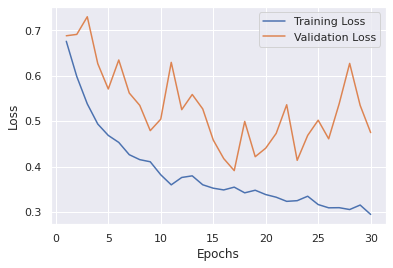

In [0]:
plt.plot(epochs, train_loss, label = 'Training Loss')
plt.plot(epochs, val_loss, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

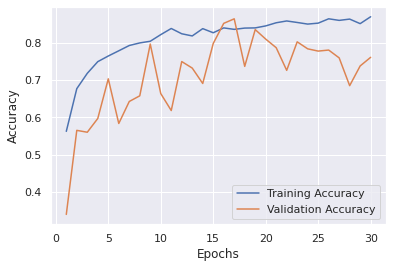

In [0]:
plt.plot(epochs, train_acc, label = 'Training Accuracy')
plt.plot(epochs, val_acc, label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

Thanks to data augmentation and dropout, we have significantly less overfitting: the training curves are rather closely tracking the validation curves and there is less extreme oscillation happening. We are now able to reach an accuracy of 82%.
